# Momentum, Volatility, and Volume Factors in U.S. Stock Returns

**ISYE 4031 Final Project**  
*Regression & Forecasting, Georgia Tech*

## Project Overview

This notebook analyzes the relationship between **momentum**, **volatility**, and **volume** factors in U.S. stock returns using S&P 500 data.

### Research Questions:
1. Do momentum indicators significantly predict future stock returns?
2. How does volatility clustering affect return predictability? 
3. Is trading volume a reliable indicator of price direction?

---

In [382]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
from bs4 import BeautifulSoup
import requests, re
import ta

---
### S&P 500 Stock List
We start by scraping the current S&P 500 stock list from a reliable financial data source.

**Data Source**: [Stock Analysis - S&P 500](https://stockanalysis.com/list/sp-500-stocks/)

**Key Information Collected**:
- Stock symbols (tickers)
- Market capitalization



In [383]:
url = 'https://stockanalysis.com/list/sp-500-stocks/'
resp = requests.get(url)
soup = BeautifulSoup(resp.text, 'html.parser')

# Find the table and extract headers
table = soup.find('table', class_='symbol-table svelte-1ro3niy')
headers = [th.get_text(strip=True) for th in table.find('tr').find_all('th')]

# Extract all row data
stocks_data = []
for row in table.find_all('tr')[1:]:  # Skip header row
    row_data = [cell.get_text(strip=True) for cell in row.find_all('td')]
    stocks_data.append(row_data)

# Create DataFrame and set No. column as index
sp500_df = pd.DataFrame(stocks_data, columns=headers)
sp500_df = sp500_df.set_index('No.')

---

### Stock Selection & Date Range Setup

**Stock Selection Process:**
- Extract first 50 companies from S&P 500 list for analysis
- Focus on established companies for reliable historical data

**Analysis Time Period:**
- **Start Date**: January 1, 2021
- **End Date**: December 27, 2024
- **Duration**: 4 years of market data
- **Purpose**: Capture post-pandemic market trends and recovery patterns

> **Note**: Using a subset of the top 50 stocks for computational efficiency and financial significance.



In [384]:
# Change this to 50 later, just 3 now for computing efficiency
num_stocks_chosen = 50

# Adding one to properly reflect the number of stocks chosen when it's 10 or more because of stocks with dots in their tickers being filtered out
num_stocks = num_stocks_chosen + 1 if num_stocks_chosen >= 10 else num_stocks_chosen

# Get the list of stock tickers from the DataFrame
stocks = sp500_df.head(num_stocks)['Symbol'].tolist()

# Filter out all tickers that contain dots (they often cause yfinance issues)
stocks = [ticker for ticker in stocks if '.' not in ticker and ticker != 'COST']

# Sort the list of stocks alphabetically
stocks.sort()

# Create start and end date variables for use later
startDate = dt.date(2021, 1, 1)
endDate = dt.date(2024, 12, 27)


# Print out list of stocks chosen and length of list
print(f"Selected stocks: {stocks}")
print(f"Total stocks: {len(stocks)}")

Selected stocks: ['AAPL', 'ABBV', 'ABT', 'AMD', 'AMZN', 'AVGO', 'AXP', 'BAC', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GE', 'GOOG', 'GOOGL', 'GS', 'HD', 'IBM', 'ISRG', 'JNJ', 'JPM', 'KO', 'LIN', 'LLY', 'LRCX', 'MA', 'MCD', 'META', 'MRK', 'MS', 'MSFT', 'MU', 'NFLX', 'NVDA', 'ORCL', 'PEP', 'PG', 'PLTR', 'PM', 'RTX', 'TMO', 'TMUS', 'TSLA', 'UNH', 'V', 'WFC', 'WMT', 'XOM']
Total stocks: 49


---

### Weekly Returns and Factor Calculation

**Objective**: Calculate weekly log returns and prepare data structure for technical indicator analysis.

**Key Metrics**:
- **Weekly Log Returns**: `ln(Close/Open) × 100` for price movement analysis
- **ROC** Rate of Change indicator for momentum analysis.
- **RVOL** Relative Volume indicator for volume analysis.
- **BBW** Bollinger Band width indicator for volatility analysis.

**Data Structure**:
- Multi-level columns for organized factor storage
- Separate columns for each technical indicator per stock
- Week numbering for time series tracking

**Download and extract relevant data on a weekly basis**

In [385]:
extended_date = startDate - dt.timedelta(days=80)

# Download weekly data
download = yf.download(
    tickers = stocks,
    start = extended_date,
    end = endDate,
    actions = False, threads = True, auto_adjust = True, rounding = True,
    group_by = 'tickers', 
    interval = '1d'
)

# Extract OHLCV data
open_data = download.xs('Open', level=1, axis=1)
close_data = download.xs('Close', level=1, axis=1)
volume_data = download.xs('Volume', level=1, axis=1)

# Convert daily to weekly data (Friday close) for analysis
weekly_open = open_data.resample('W-FRI').first()
weekly_close = close_data.resample('W-FRI').last()
weekly_volume = volume_data.resample('W-FRI').sum()

# Filter for display purposes
analysis_start = pd.Timestamp('2021-01-01')
analysis_mask = (weekly_close.index >= analysis_start)

analysis_open = weekly_open.loc[analysis_mask]
analysis_close = weekly_close.loc[analysis_mask]

[*********************100%***********************]  49 of 49 completed


In [386]:
# Create MultiIndex DataFrame (indexed by full weekly data for proper alignment)
columns = []
for ticker in stocks:
    # extend to include log return, ROC, RVOL, BBW for each ticker
    columns.extend([(ticker, 'Log_Return_%'), (ticker, 'ROC'), (ticker, 'RVOL'), (ticker, 'BBW')])
# Make sub-columns accessible
multi_columns = pd.MultiIndex.from_tuples(columns, names=['Ticker', 'Metric'])
# Construct df with weekly data indexed with ALL weekly dates (including lookback period)
weekly_data = pd.DataFrame(index=weekly_close.index, columns=multi_columns)

In [387]:
# Create function to lag indicators by one week. Returns values aligned with weekly_close.index
def lag_indicator(weekly_full):
    lagged_values = []
    for current_week in weekly_close.index:
        prev_week_candidates = weekly_full.index[weekly_full.index < current_week]
        if len(prev_week_candidates) > 0:
            prev_week = prev_week_candidates[-1]
            lagged_values.append(weekly_full.loc[prev_week])
        else:
            lagged_values.append(np.nan)
    return lagged_values

**Calculate and store key indicators**

In [388]:
# Calculate indicators for each stock using TA library
for ticker in stocks:

    # Get full daily time series for calculations (including lookback period)
    ticker_weekly_close = weekly_close[ticker].dropna()
    ticker_weekly_volume = weekly_volume[ticker].dropna()
    
    # 1. Log Returns (current week - already calculated from weekly data)
    # Calculate weekly log returns
    log_returns = (np.log(weekly_close / weekly_open) * 100).round(2)

    weekly_data[(ticker, 'Log_Return_%')] = log_returns[ticker]
    
    # 2. Rate of Change (ROC) - weekly-based 5-week ROC (weekly change_i / weekly change_{i-5}), lagged by 1 week
    # Use the DataFrame `weekly_roc_5w` and lag it by one week (we want t-1 values predicting t)

    # weekly_change: change in close from open
    weekly_change = weekly_close - weekly_open.round(2)
    # weekly_roc_5w: weekly_change_i divided by weekly_change_{i-5} (as percent)
    weekly_roc_5w = (((weekly_change / weekly_change.shift(5))) * 100).round(2)
    # Replace inf values with NaN (occurs when denominator is zero - no price movement in week i-5)
    weekly_roc_5w = weekly_roc_5w.replace([np.inf, -np.inf], np.nan)

    if ticker in weekly_roc_5w.columns:
        roc_weekly_lagged = weekly_roc_5w[ticker].reindex(weekly_close.index).shift(1)
    else:
        roc_weekly_lagged = pd.Series(np.nan, index=weekly_close.index)
    weekly_data[(ticker, 'ROC')] = roc_weekly_lagged.round(2)


    # 3. 36-day Bollinger Band Width (BBW) lagged by 1 week
    bb_indicator = ta.volatility.BollingerBands(close=ticker_weekly_close, window=7, window_dev=2)
    bb_upper = bb_indicator.bollinger_hband()
    bb_lower = bb_indicator.bollinger_lband()
    bb_mavg = bb_indicator.bollinger_mavg()
    
    # Calculate BBW as percentage width
    bbw_weekly_full = ((bb_upper - bb_lower) / bb_mavg) * 100
    bbw_lagged_values = lag_indicator(bbw_weekly_full)
    weekly_data[(ticker, 'BBW')] = pd.Series(bbw_lagged_values, index=weekly_close.index).round(2)

    # 4. Relative Volume (RVOL) - Current volume vs 50-day SMA using TA library, lagged by 1 week
    volume_sma_50d = ta.trend.SMAIndicator(close=ticker_weekly_volume, window=10).sma_indicator()
    rvol_weekly_full = ticker_weekly_volume / volume_sma_50d
    rvol_lagged_values = lag_indicator(rvol_weekly_full)
    weekly_data[(ticker, 'RVOL')] = pd.Series(rvol_lagged_values, index=weekly_close.index).round(2)


# Filter to analysis period only
weekly_data_analysis = weekly_data.loc[analysis_start:].copy()

# Add week numbers as a separate column
weekly_data_analysis.insert(0, 'Week', range(1, len(weekly_data_analysis) + 1))

print(f"Regression Format:")
print("Return_{{i,t}} = β_MOM×ROC_36d_{{i,t-1}} + β_BBW×BBW_36d_{{i,t-1}} + β_VOL×RVOL_50d_{{i,t-1}} + ε_{{i,t}}")


display(weekly_data_analysis.head())


Regression Format:
Return_{{i,t}} = β_MOM×ROC_36d_{{i,t-1}} + β_BBW×BBW_36d_{{i,t-1}} + β_VOL×RVOL_50d_{{i,t-1}} + ε_{{i,t}}


Ticker     Week         AAPL                               ABBV                \
Metric          Log_Return_%      ROC  RVOL    BBW Log_Return_%     ROC  RVOL   
Date                                                                            
2021-01-01    1        -0.97  -439.61  0.83  16.54         3.32   56.94  0.38   
2021-01-08    2        -1.11   217.24  0.86  19.26         0.08  118.52  0.52   
2021-01-15    3        -1.60   -28.02  1.21  18.23         4.33    3.93  1.06   
2021-01-22    4         8.47 -2000.00  0.98  13.00        -0.36 -672.41  1.09   
2021-01-29    5        -8.08   278.23  0.90  15.31        -6.84   13.47  0.72   

Ticker                     ABT  ...   WFC                 WMT                \
Metric        BBW Log_Return_%  ...  RVOL    BBW Log_Return_%     ROC  RVOL   
Date                            ...                                           
2021-01-01  10.49         0.48  ...  0.69  29.62         0.07  700.00  0.93   
2021-01-08   8.17         1.88  ...  0.44  20.20         1.61    7.69  0.74   
2021-01-15   5.64         0.48  ...  1.23  19.31        -0.93  -86.90  1.20   
2021-01-22   9.39         0.98  ...  1.44  19.41         1.17  144.83  1.14   
2021-01-29  11.69         8.91  ...  0.71  19.63        -3.41  -98.15  0.75   

Ticker                    XOM                       
Metric       BBW Log_Return_%     ROC  RVOL    BBW  
Date                                                
2021-01-01  6.60        -1.14  -77.36  0.50  26.61  
2021-01-08  7.05         9.25  -17.65  0.61  19.64  
2021-01-15  6.46         6.14  213.55  1.13  15.51  
2021-01-22  4.41        -2.15  119.90  1.23  20.83  
2021-01-29  3.45        -4.50   63.91  0.73  22.50  

[5 rows x 197 columns]

Function creating dataframe with each week's metrics

In [394]:
# Get unique ticker names from the MultiIndex columns. First one is 'Week' so skip it
stock_tickers = weekly_data_analysis.columns.get_level_values('Ticker').unique().tolist()
stock_tickers = [ticker for ticker in stock_tickers if ticker != 'Week']

# Create dataframe for week data where row is stock ticker and columns are metrics
def get_week_x_data(tickers, week_number):
    week_data = pd.DataFrame(index=tickers, columns=['Log_Return_%', 'ROC', 'RVOL', 'BBW'])
    
    index = week_number - 1  # Convert to zero-based index
    
    for ticker in tickers:
        # Access each metric individually from the MultiIndex DataFrame
        week_data.loc[ticker, 'Log_Return_%'] = weekly_data_analysis[(ticker, 'Log_Return_%')].iloc[index]
        week_data.loc[ticker, 'ROC'] = weekly_data_analysis[(ticker, 'ROC')].iloc[index]
        week_data.loc[ticker, 'RVOL'] = weekly_data_analysis[(ticker, 'RVOL')].iloc[index]
        week_data.loc[ticker, 'BBW'] = weekly_data_analysis[(ticker, 'BBW')].iloc[index]
    
    # Drop row if NaN found in any column
    week_data_clean = week_data.dropna(subset=['Log_Return_%', 'ROC', 'RVOL', 'BBW'])
    return week_data_clean

# Output
week_num = 5  # Start from week 10 to ensure indicators have sufficient lookback
week_result = get_week_x_data(stock_tickers, week_num)
print(f"Week {week_num} data:")
display(week_result)

Week 5 data:


,Log_Return_%,ROC,RVOL,BBW
AAPL,-8.08,278.23,0.9,15.31
ABBV,-6.84,13.47,0.72,11.69
ABT,8.91,75.37,0.89,7.45
AMD,-9.46,87.06,1.04,9.85
AMZN,-3.75,316.04,0.99,7.96
AVGO,-4.15,53.17,0.86,16.09
AXP,-6.64,-15.37,0.95,9.77
BAC,-5.34,381.82,0.96,21.38
CAT,-4.14,-651.52,0.68,14.48
CRM,-1.82,240.33,0.7,7.83


**Get Regression Coefficients**

In [ ]:
import statsmodels.api as sm

y = week_result['Log_Return_%'].values.astype(float)
X = week_result[['ROC', 'RVOL', 'BBW']].values.astype(float)
model = sm.OLS(y,X).fit()

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.524
Model:                            OLS   Adj. R-squared (uncentered):              0.493
Method:                 Least Squares   F-statistic:                              16.85
Date:                Thu, 13 Nov 2025   Prob (F-statistic):                    1.59e-07
Time:                        14:24:51   Log-Likelihood:                         -131.84
No. Observations:                  49   AIC:                                      269.7
Df Residuals:                      46   BIC:                                      275.4
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Create scatterplot of Rate of Change vs Log Return for a given week

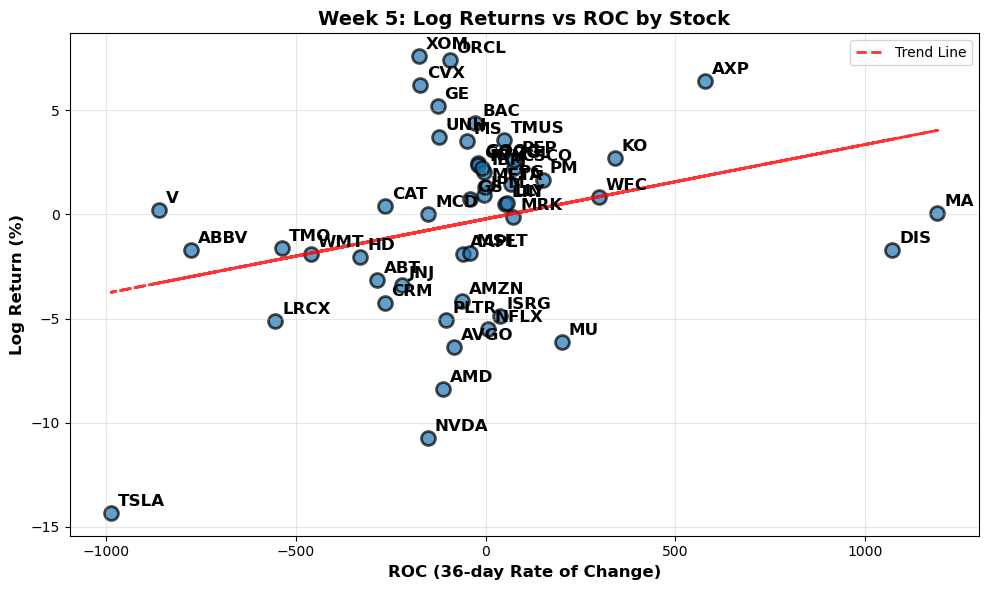

In [396]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract week 10 data to ensure non-NaN values
week_data = weekly_data_analysis.iloc[9]  # Week 10 (0-indexed)

# Prepare data for scatter plot
plot_data = []
for ticker in stocks:
    log_return = week_data[(ticker, 'Log_Return_%')]
    roc = week_data[(ticker, 'ROC')]
    
    # Only include if both values are not NaN
    if pd.notna(log_return) and pd.notna(roc):
        plot_data.append({
            'Ticker': ticker,
            'Log_Return_%': log_return,
            'ROC': roc
        })

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['ROC'], plot_df['Log_Return_%'], 
           s=100, alpha=0.7, edgecolors='black', linewidth=2)

# Add labels for each point
for i, row in plot_df.iterrows():
    plt.annotate(row['Ticker'], 
                (row['ROC'], row['Log_Return_%']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=12, fontweight='bold')

plt.xlabel('ROC (36-day Rate of Change)', fontsize=12, fontweight='bold')
plt.ylabel('Log Return (%)', fontsize=12, fontweight='bold')
plt.title(f'Week {week_num}: Log Returns vs ROC by Stock', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add a trend line if we have data
if len(plot_df) > 1:
    z = np.polyfit(plot_df['ROC'], plot_df['Log_Return_%'], 1)
    p = np.poly1d(z)
    plt.plot(plot_df['ROC'], p(plot_df['ROC']), 
             "r--", alpha=0.8, linewidth=2, label=f'Trend Line')
    plt.legend()

plt.tight_layout()
plt.show()

Original data shape: (49, 4)
Cleaned data shape: (49, 4)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

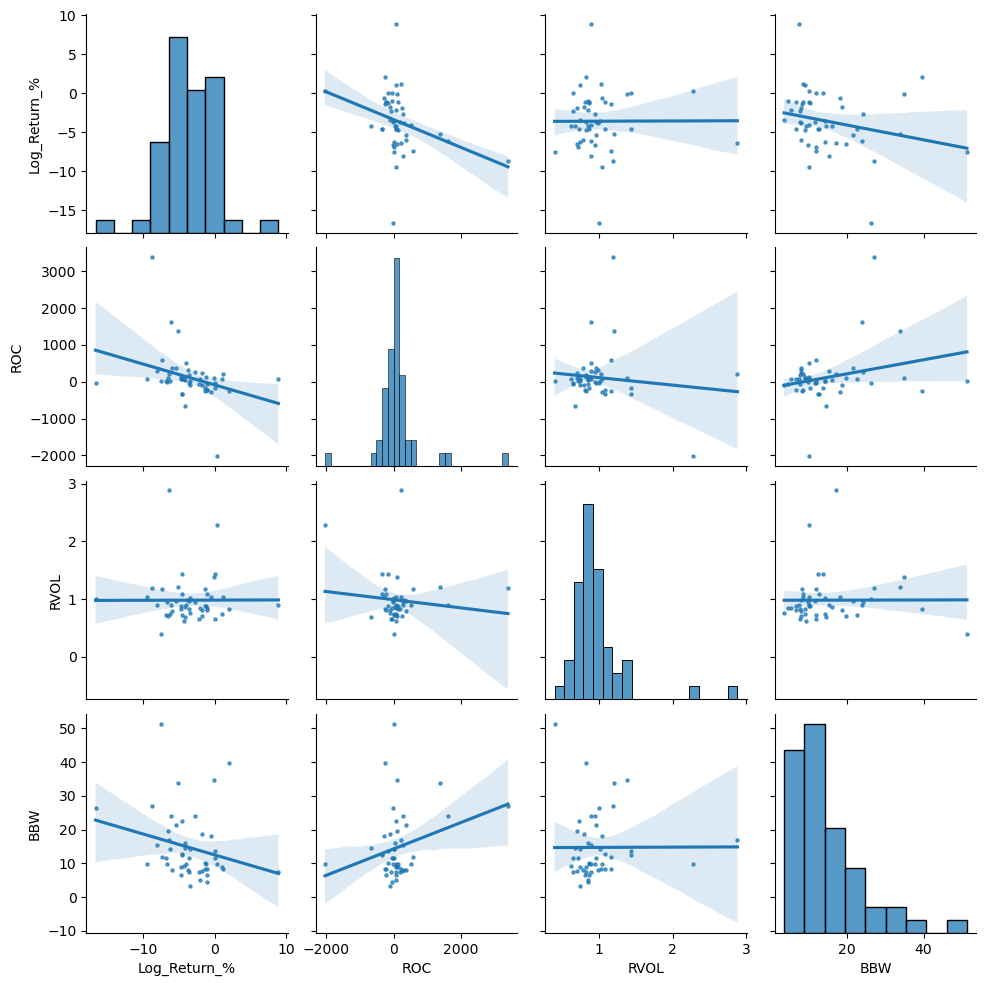

In [397]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# display(week_result)

# Clean the data by replacing inf and -inf values with NaN, then drop NaN rows
week_result_clean = week_result.replace([np.inf, -np.inf], np.nan).infer_objects(copy=False).dropna()

print(f"Original data shape: {week_result.shape}")
print(f"Cleaned data shape: {week_result_clean.shape}")

# Create pairplot for the cleaned week result with trend lines in each scatter plot
# sns.pairplot(week_result_clean, kind='scatter', plot_kws={'alpha': 1})
sns.pairplot(week_result_clean, kind='reg', plot_kws={'scatter_kws': {'alpha': 0.7, 's': 5}}, 
             diag_kind='hist')
plt.show()